# 주식변동 예측하기
### 순서
1. 삼성
2. Apple
3. Tesla
4. Microsoft

## Samsung

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: Close, dtype: float64)

In [3]:
ts_log = np.log(ts)

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [5]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

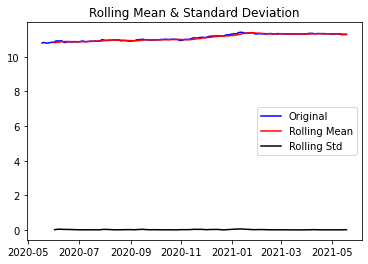

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


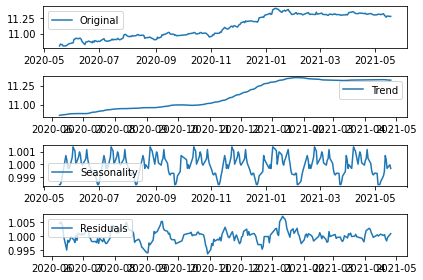

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


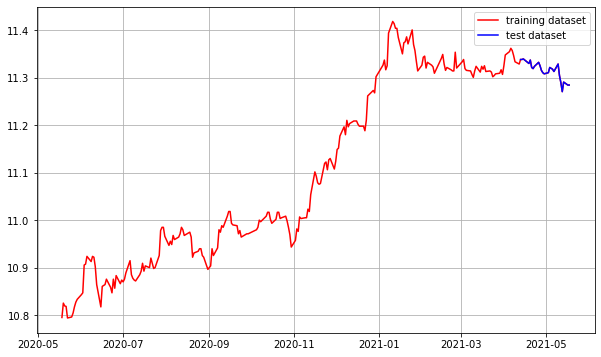

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


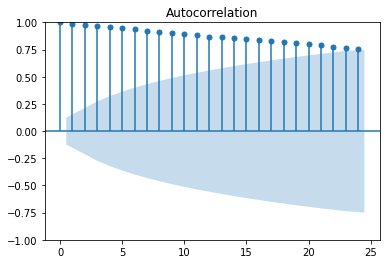

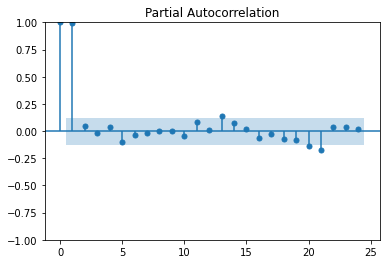

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


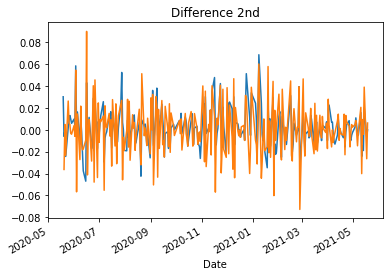

In [10]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 10 Feb 2022   AIC                          -1156.722
Time:                        07:29:24   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


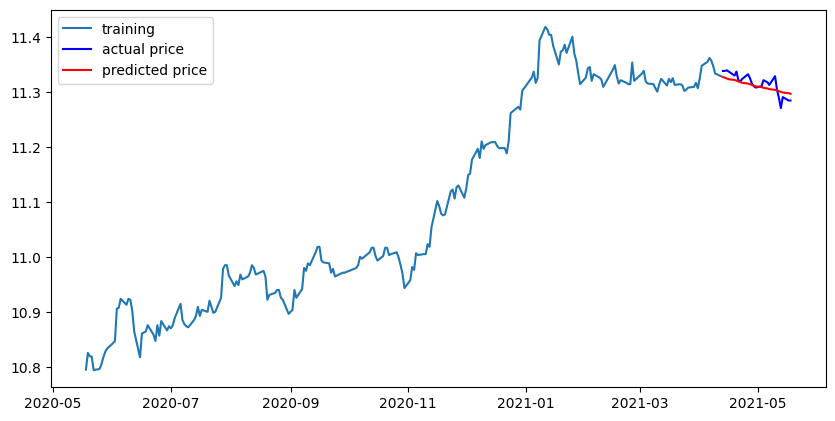

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


위의 과정을 함수로 만들어 수행해보도록 한다.

In [14]:
def return_ts(file_path):
    # 파일을 불러와 첫 다섯 행을 보여줌
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    ts = df['Close']
    
    print("파일 확인")
    print(ts.head())
    return ts

def return_ts_log(ts):
    # 결측치 처리
    ts = ts.interpolate(method='time')
    print("결측치 확인:", ts[ts.isna()])
    
    # 로그 변환
    ts_log = np.log(ts)
    return ts_log

def check_stationary(ts_log,window=12):
    # 정성적 그래프 분석
    print("정성적 그래프 분석")
    plot_rolling_statistics(ts_log, window=window)
    print("----------------------------------------------")
    
    #정량적 Augmented Dicky-Fuller Test
    print("정량적 그래프 분석")
    augmented_dickey_fuller_test(ts_log)

def time_series_decomposition(ts_log, period=30):
    #시계열 분해 (Time Series Decomposition)
    print("시계열 분해")
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = period) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    print("----------------------------------------------")
    
    # Residual 안정성 확인
    print("Residual 안정성 확인")
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

def train_test_data(ts_log, ratio=0.8):
    print("train data, test data 분리")
    train_data, test_data = ts_log[:int(len(ts_log)*ratio)], ts_log[int(len(ts_log)*ratio):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    plt.show()
    
    return train_data, test_data

def acf_pacf(ts_log):
    print('ACF, PACF 그래프 출력')
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

def differencing(ts_log, i):
    print('차분 안정성 확인')
    # 1차 차분
    diff = ts_log.diff(periods=1).iloc[1:]
    diff.plot(title=f'Difference {i}st')
    plt.show()
    augmented_dickey_fuller_test(diff)
    
    return diff
    
    
def set_arima(train_data, order):
    print('ARIMA 모델')
    model = ARIMA(train_data, order=order)  
    fitted_m = model.fit() 

    print(fitted_m.summary())
    print("----------------------------------------------")
    print("예측 결과")
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    return fc

def get_score(test_data, fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

## Apple

In [15]:
apple_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
ts = return_ts(apple_filepath)

파일 확인
Date
2021-02-10    135.389999
2021-02-11    135.130005
2021-02-12    135.369995
2021-02-16    133.190002
2021-02-17    130.839996
Name: Close, dtype: float64


In [16]:
ts_log = return_ts_log(ts)

결측치 확인: Series([], Name: Close, dtype: float64)


정성적 그래프 분석


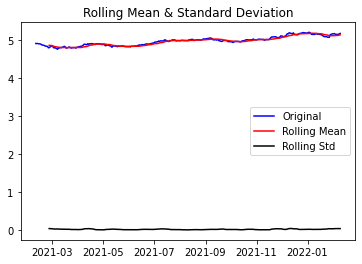

----------------------------------------------
정량적 그래프 분석
Results of Dickey-Fuller Test:
Test Statistic                  -0.410001
p-value                          0.908416
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [17]:
check_stationary(ts_log)


시계열 분해


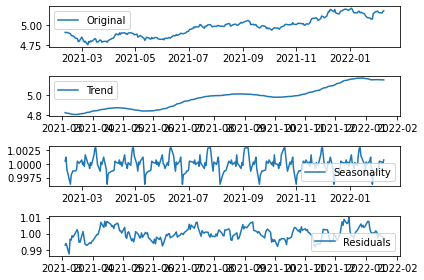

----------------------------------------------
Residual 안정성 확인
Results of Dickey-Fuller Test:
Test Statistic                  -4.747775
p-value                          0.000068
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


In [18]:
time_series_decomposition(ts_log)

train data, test data 분리


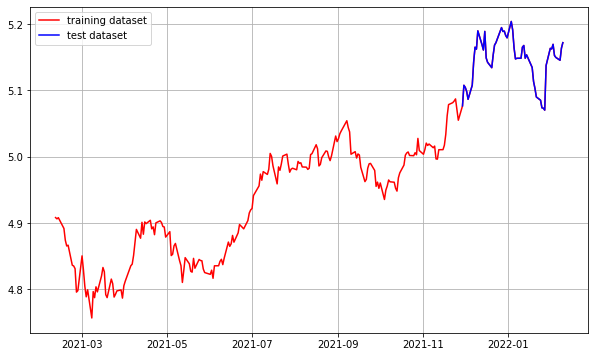

In [19]:
train_data, test_data = train_test_data(ts_log)

ACF, PACF 그래프 출력


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


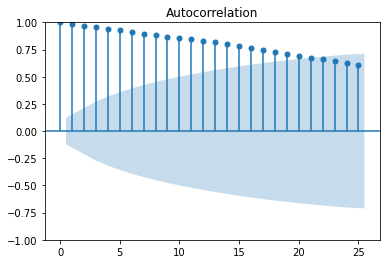

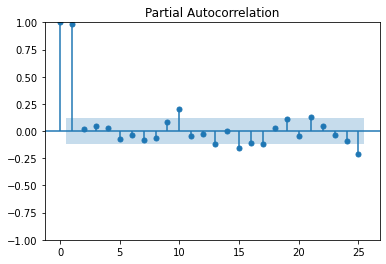

In [20]:
acf_pacf(ts_log)

차분 안정성 확인


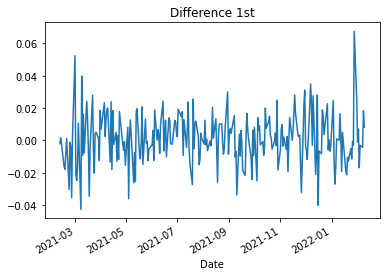

Results of Dickey-Fuller Test:
Test Statistic                -9.969701e+00
p-value                        2.257472e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


In [21]:
diff1 = differencing(ts_log, 1)

차분 안정성 확인


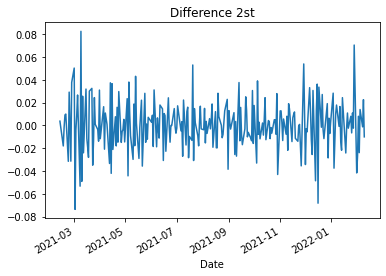

Results of Dickey-Fuller Test:
Test Statistic                -7.667778e+00
p-value                        1.623806e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


In [22]:
diff2 = differencing(diff1, 2)

차분 안정성 확인


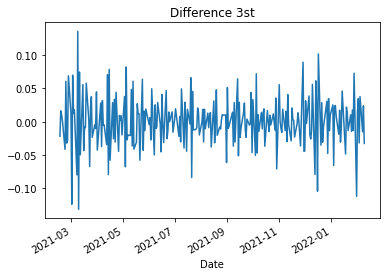

Results of Dickey-Fuller Test:
Test Statistic                -8.789942e+00
p-value                        2.254787e-14
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


In [23]:
diff3 = differencing(diff2, 3)

pacf를 나타낸 그래프를 보면 p가 2 이상인 구간에서 0에 가까워지고 있기 때문에 p를 1로 설정해준다. d의 값은 3으로 설정한다.

ARIMA 모델


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  202
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 567.390
Date:                Thu, 10 Feb 2022   AIC                          -1122.781
Time:                        07:29:27   BIC                          -1102.931
Sample:                             0   HQIC                         -1114.749
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9594      0.124     40.038      0.000       4.717       5.202
ar.L1          0.9936      0.009    114.937      0.000       0.977       1.011
ma.L1         -0.0533      0.072     -0.737      0.4

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


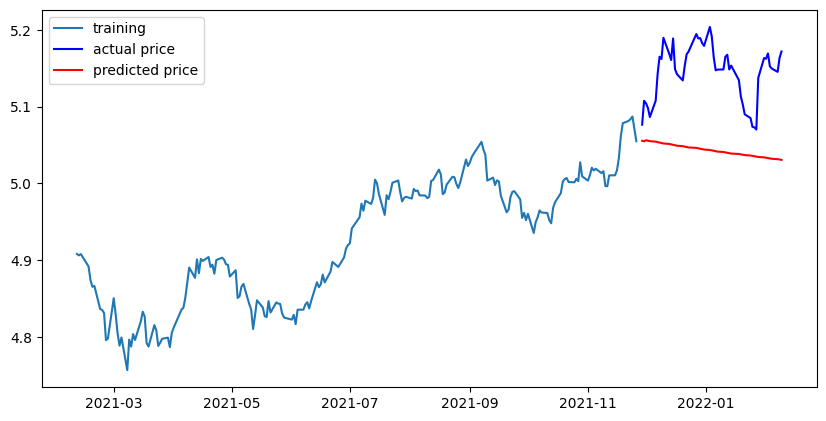

In [24]:
fc = set_arima(train_data, (1, 0, 3))

In [25]:
get_score(test_data, fc)

MSE:  318.9711030552288
MAE:  16.74862563256959
RMSE:  17.859762122022477
MAPE: 9.64%


## Tesla

In [26]:
tsla_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
ts = return_ts(tsla_filepath)

파일 확인
Date
2021-02-10    804.820007
2021-02-11    811.659973
2021-02-12    816.119995
2021-02-16    796.219971
2021-02-17    798.150024
Name: Close, dtype: float64


In [27]:
ts_log = return_ts_log(ts)

결측치 확인: Series([], Name: Close, dtype: float64)


정성적 그래프 분석


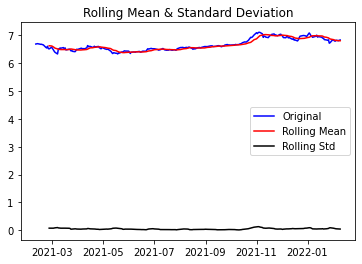

----------------------------------------------
정량적 그래프 분석
Results of Dickey-Fuller Test:
Test Statistic                  -1.228461
p-value                          0.661234
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [28]:
check_stationary(ts_log)

시계열 분해


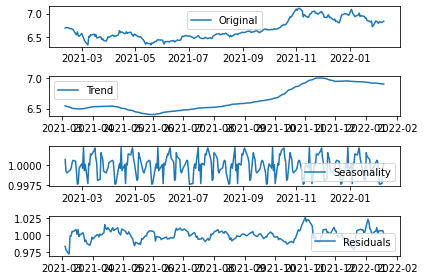

----------------------------------------------
Residual 안정성 확인
Results of Dickey-Fuller Test:
Test Statistic                -5.951004e+00
p-value                        2.147324e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


In [29]:
time_series_decomposition(ts_log)

train data, test data 분리


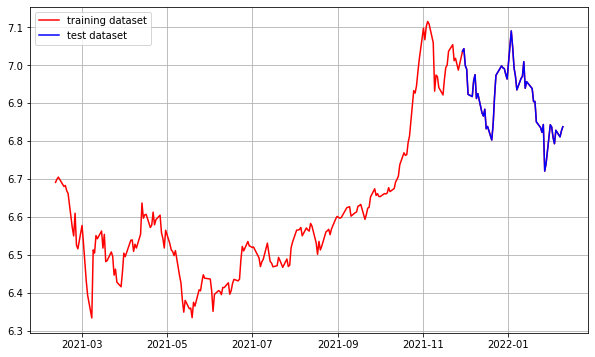

In [30]:
train_data, test_data = train_test_data(ts_log)

ACF, PACF 그래프 출력


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


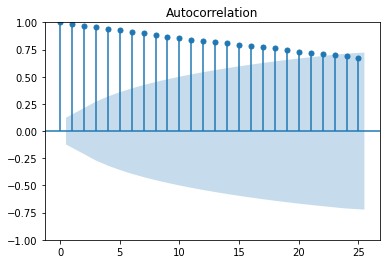

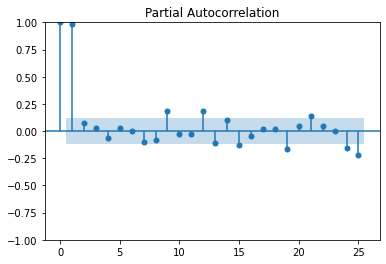

In [31]:
acf_pacf(ts_log)

차분 안정성 확인


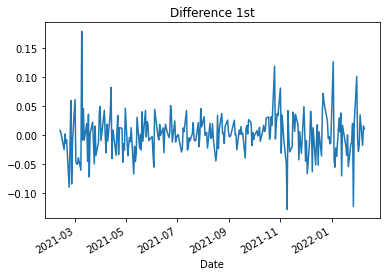

Results of Dickey-Fuller Test:
Test Statistic                -1.688748e+01
p-value                        1.051349e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [32]:
diff1 = differencing(ts_log, 1)

차분 안정성 확인


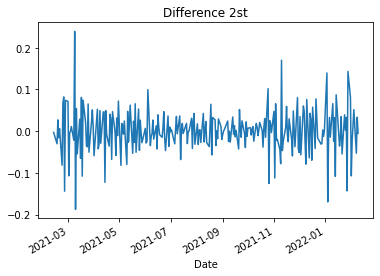

Results of Dickey-Fuller Test:
Test Statistic                -6.943489e+00
p-value                        1.011002e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


In [33]:
diff2 = differencing(diff1, 2)

차분 안정성 확인


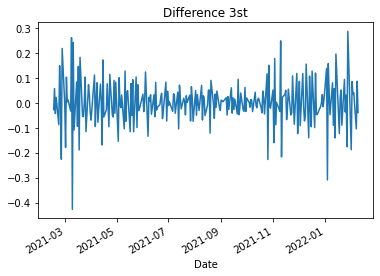

Results of Dickey-Fuller Test:
Test Statistic                -8.157489e+00
p-value                        9.334751e-13
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


In [34]:
diff3 = differencing(diff2, 3)

pacf를 나타낸 그래프를 보면 p가 2 이상인 구간에서 0에 가까워지고 있기 때문에 p를 1로 설정해준다. d의 값은 3으로 설정한다.

ARIMA 모델


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  202
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 401.184
Date:                Thu, 10 Feb 2022   AIC                           -790.368
Time:                        07:29:30   BIC                           -770.519
Sample:                             0   HQIC                          -782.337
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6817      0.176     37.873      0.000       6.336       7.027
ar.L1          0.9845      0.013     78.283      0.000       0.960       1.009
ma.L1         -0.0600      0.066     -0.908      0.3

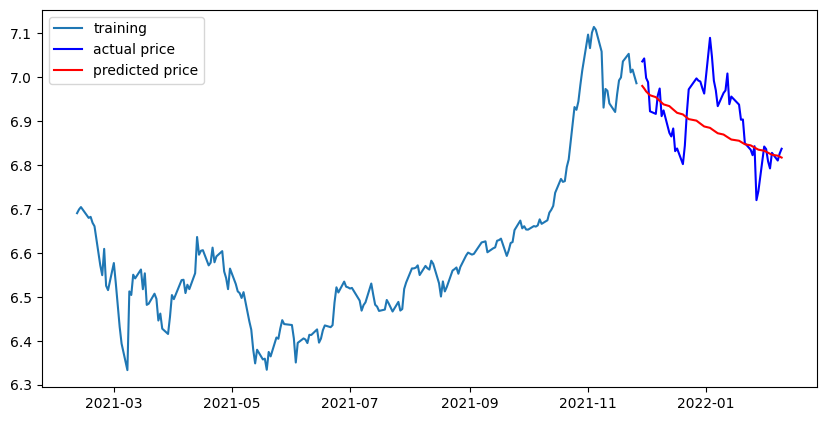

In [35]:
fc = set_arima(train_data, (1, 0, 3))

In [36]:
get_score(test_data, fc)

MSE:  5887.574635769786
MAE:  60.892106723454376
RMSE:  76.73053261752968
MAPE: 5.91%


## Microsoft

In [37]:
msft_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/MSFT.csv'
ts = return_ts(msft_filepath)

파일 확인
Date
2021-02-10    242.820007
2021-02-11    244.490005
2021-02-12    244.990005
2021-02-16    243.699997
2021-02-17    244.199997
Name: Close, dtype: float64


In [38]:
ts_log = return_ts_log(ts)

결측치 확인: Series([], Name: Close, dtype: float64)


정성적 그래프 분석


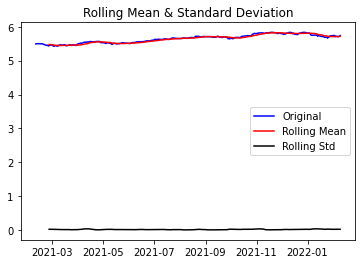

----------------------------------------------
정량적 그래프 분석
Results of Dickey-Fuller Test:
Test Statistic                  -1.161048
p-value                          0.690124
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [39]:
check_stationary(ts_log)


시계열 분해


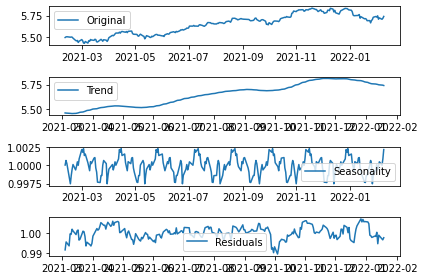

----------------------------------------------
Residual 안정성 확인
Results of Dickey-Fuller Test:
Test Statistic                  -5.516229
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


In [40]:
time_series_decomposition(ts_log)

train data, test data 분리


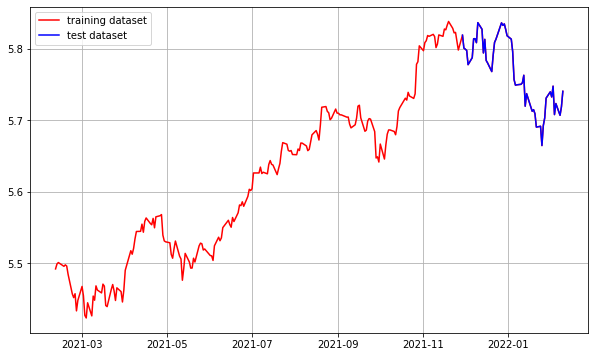

In [41]:
train_data, test_data = train_test_data(ts_log)

ACF, PACF 그래프 출력


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


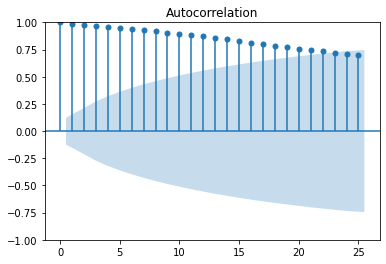

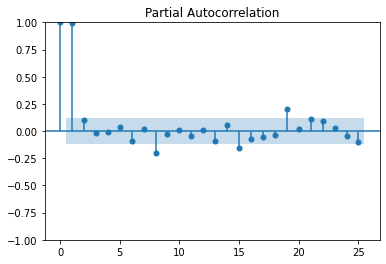

In [42]:
acf_pacf(ts_log)

차분 안정성 확인


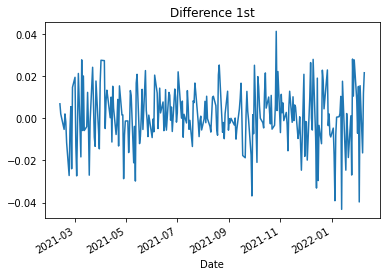

Results of Dickey-Fuller Test:
Test Statistic                -1.659486e+01
p-value                        1.785608e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [43]:
diff1 = differencing(ts_log, 1)

차분 안정성 확인


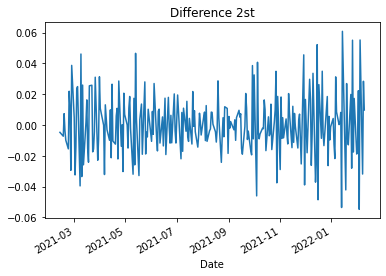

Results of Dickey-Fuller Test:
Test Statistic                -7.319944e+00
p-value                        1.201500e-10
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


In [44]:
diff2 = differencing(diff1, 2)

차분 안정성 확인


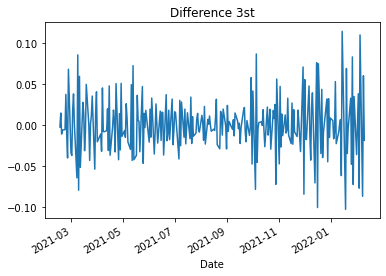

Results of Dickey-Fuller Test:
Test Statistic                -9.371804e+00
p-value                        7.343370e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


In [45]:
diff3 = differencing(diff2, 3)

pacf를 나타낸 그래프를 보면 p가 2 이상인 구간에서 0에 가까워지고 있기 때문에 p를 1로 설정해준다.

ARIMA 모델
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  202
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 599.608
Date:                Thu, 10 Feb 2022   AIC                          -1189.216
Time:                        07:29:32   BIC                          -1172.675
Sample:                             0   HQIC                         -1182.523
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6120      0.299     18.781      0.000       5.026       6.198
ar.L1          0.9980      0.006    175.856      0.000       0.987       1.009
ma.L1          0.0566      0.073      0.779

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

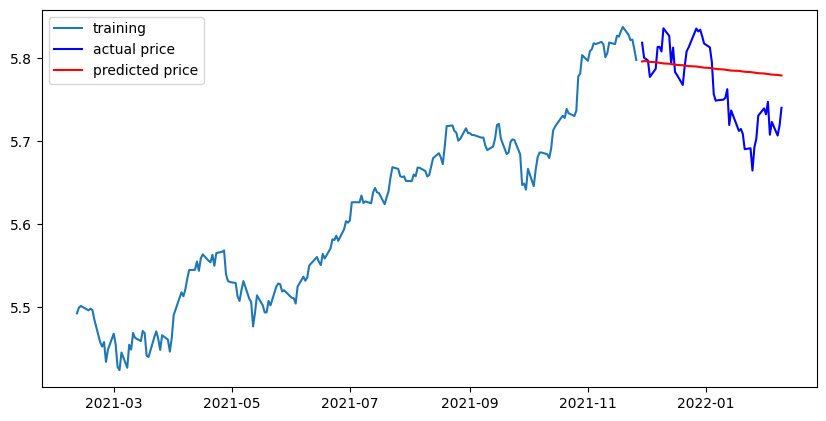

In [46]:
fc = set_arima(train_data, (1, 0, 2))

In [47]:
get_score(test_data, fc)

MSE:  229.66956173246967
MAE:  12.551332291087299
RMSE:  15.154852745324504
MAPE: 4.03%


## 회고

처음 테슬라의 주식을 예측했을 때 MAPE 값이 약 17퍼센트가 나와서 window나 period, train_set과 test_set의 비율을 조절해 MAPE의 값을 낮추려고 했었다. window와 period는 소용이 없었고, train_set과 test_set의 비율을 8:2로 조절하니 값이 낮아졌다. 하지만 이런 식으로 조정해서 원하는 결과를 얻는 것은 ARIMA를 활용해보는 목적과는 맞지 않다고 생각해 acf와 pacf 그래프, 그리고 d차 차분을 통해 값을 조정해보고자 했다. 

 acf와 pacf의 그래프가 보여준 결과는 세 회사의 데이터 모두 삼성 데이터를 이용해 계산했을 때와 크게 차이가 없어 p 값은 1로 고정해 계산을 했다. d 같은 경우도 크게 차이는 없었지만 차분화를 한 번 더 시도하고 그에 따라서 2 또는 3 값을 넣어서 계산했다.